<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/FasterRCNN/VGG16_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

/content/drive/MyDrive/Colab Notebooks/20220819
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import layoutparser as lp
from pycocotools.coco import COCO

from engine import train_one_epoch, evaluate
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [ ]:
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
class WoodDataset(Dataset):
    def __init__(self, image_dir, coco, transforms=None, mode='train'):
        super().__init__()
        self.image_dir = image_dir
        self.coco = coco        
        self.transforms = transforms
        
        
    def __getitem__(self, index : int):
        index += 1
        image_id = index
        image_info = self.coco.imgs[index]
        anns = self.coco.loadAnns(self.coco.getAnnIds([index]))
        n = len(anns)

        image = cv2.imread(os.path.join(self.image_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        boxes=np.zeros((n, 4))
        area = np.zeros(n)
        iscrowd = np.zeros(n)
        labels = np.zeros(n, dtype = np.int64)
        image_ids = np.zeros(n)

        for i in range(n):
          boxes[i, :] = anns[i]['bbox']
          area[i] = anns[i]['area']
          iscrowd[i] = anns[i]['iscrowd']
          labels[i] = anns[i]['category_id']
          image_ids[i] = anns[i]['image_id']
        boxes_yolo = boxes.copy()
        boxes_yolo[:, 2] = boxes[:,0] + boxes[:,2]
        boxes_yolo[:, 3] = boxes[:,1] + boxes[:,3]

        check = area > 10
        area = area[check]
        boxes_yolo = boxes_yolo[check]
        labels = labels[check]
        iscrowd = iscrowd[check]
        image_ids = torch.tensor([index])

        boxes = torch.as_tensor(boxes_yolo, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_ids = torch.as_tensor(image_ids, dtype=torch.int64)
            
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_ids
        target['area'] = area
        target['iscrowd'] = iscrowd
            
        if self.transforms:
                sample = {
                    'image': image, 'bboxes': target['boxes'], 'labels': target['labels']
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'] = target['boxes'].type(torch.float32)
        return  image, target
        
    def __len__(self) -> int:
        return len(self.coco.imgs)

In [ ]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip, ISONoise, RandomContrast
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ISONoise(), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_data = WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [ ]:
batch_size = 8
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
from torchvision.models import vgg16
class VGG16_FRCNN(torch.nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.vgg16 = vgg16().features
      self.out_channels = 512
  def forward(self, x):
    return self.vgg16(x)

In [ ]:
modelname = 'VGG16'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(VGG16_FRCNN(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)
model.load_state_dict(torch.load(os.path.join('models', 'VGG16_SGD_epoch_20.pth')))

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9)
lr_scheduler = None

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): VGG16_FRCNN(
    (vgg16): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 

In [ ]:
num_epochs = 500
total_train_loss = []
total_valid_loss = []


In [ ]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('logs', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)

In [ ]:
torch.manual_seed(1)
model.train()
t0 = time.time()
best_val_loss = 10000.0
last_update_epoch = 0
for epoch in range(0, num_epochs):

    train_loss = []
    valid_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        n += 1
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        batch_size = len(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())     # Returns losses and detections
        loss_value = losses.item()
        train_loss.append(loss_value)

        optimizer.zero_grad()
        losses = losses.to(torch.float32)
        losses.backward()
        optimizer.step()
        if n % 30 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] \t loss: {np.mean(train_loss):.4f} \t Training time: {tstr}')
      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
############################# valid #########################################           
    valid_loss = []        
    for val_images, val_targets in valid_data_loader:
        val_images = list(val_image.to(device) for val_image in val_images)
        val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

        val_loss_dict = model(val_images, val_targets)
        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()
        valid_loss.append(val_loss_value)
        # val_loss_hist.send(val_loss_value)

############################ log ###########################################
    epoch_train_loss = np.mean(train_loss)
    epoch_valid_loss = np.mean(valid_loss)
    now = time.time()
    writer.add_scalar('Loss/train', epoch_train_loss, epoch, now)
    writer.add_scalar('Loss/val', epoch_valid_loss, epoch, now)

############################ save ##########################################   
    if epoch_valid_loss < best_val_loss:
        best_val_loss = epoch_valid_loss
        best_model = model
        print(f'Model Updated! \t Validation Loss: {best_val_loss:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(best_model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch   
#############################################################################
writer.close()

TypeError: ignored

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou

idx = 15
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

In [ ]:
bbox_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox = rec['boxes'][bbox_idx].cpu()
labels = rec['labels'][bbox_idx].cpu()

In [ ]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([8, 6, 2])

Text(0.5, 1.0, 'Gt')

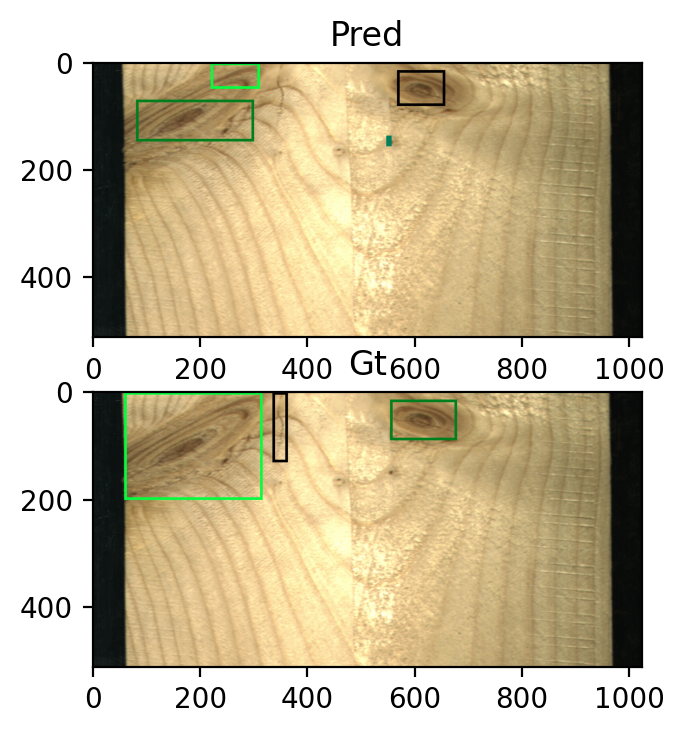

In [ ]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [ ]:
result = {'boxes':bbox.cpu(), 
          'idx': idx, 
          'labels': labels.cpu()}
# np.save('test.npy', result)
# test = np.load('test.npy', allow_pickle=True)

In [ ]:
import pickle
# with open('test.dict', 'wb') as f:
#   pickle.dump(result, f)

with open('test.dict', 'rb') as f:
  a = pickle.load(f)
a

{'boxes': tensor([[566.8190,  15.8686, 655.2360,  81.5210],
         [ 80.7732,  70.6825, 299.7254, 147.6548],
         [219.6724,   1.2643, 310.7099,  49.6471],
         [546.0529, 137.2273, 555.8708, 156.8440]], requires_grad=True),
 'idx': 15,
 'labels': tensor([2, 2, 2, 2])}

In [ ]:
cm

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.6202, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3279, 0.0857, 0.0000]], grad_fn=<DivBackward0>)

In [ ]:
cm = box_iou(bbox_gt, a['boxes'])
TP = (cm >= 0.5).sum()
FP = len(bbox) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc


tensor(0.2500)

In [ ]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
ious = []
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))
for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1


  # for i in range(len(bbox_gt)):
  #   box = np.int32(bbox_gt[i])
  #   label = np.int32(labels_gt[i])
  #   gt[label, box[1]:box[3], box[0]:box[2]] = True

  # for i in range(len(bbox_pred)):
  #   box = np.int32(bbox_pred[i].cpu().detach().numpy())
  #   label = np.int32(labels_pred[i].cpu())
  #   pred[label, box[1]:box[3], box[0]:box[2]] = True
  
  # inter = gt & pred
  # union = gt | pred
  # iou = inter.sum() / (union.sum()+eps)
  # ious.append(iou)

  # TP = (gt==1) & (pred==1)
  # FP = (pred==1) ^ TP
  # FN = (gt==1) ^TP

  # TP = TP.sum()
  # FP = FP.sum()
  # FN = FN.sum()

  
  # precision = TP/(TP+FP+eps)
  # recall = TP/(TP+FN+eps)

  # precisions.append(precision)
  # recalls.append(recall)

  if (idx+1) % 30 == 0:
    print(f'Done {idx+1}/{len(test_data)}')


Done 30/361
Done 60/361
Done 90/361
Done 120/361
Done 150/361
Done 180/361
Done 210/361
Done 240/361
Done 270/361
Done 300/361
Done 330/361
Done 360/361


In [ ]:
# with open(os.path.join('Classification_matrix', 'VGG16_FRCNN.npy'), 'wb') as f:
#   np.save(f, cls_cm)

In [ ]:
cls_cm

array([[  0.,   4.,   7.,   0.,   1.,   0.,   0.,   2.],
       [  0., 440.,   0.,   0.,  36.,   3.,   1.,   7.],
       [  0.,  16.,  21.,   3.,   0.,   0.,   0.,   0.],
       [  0.,  40.,   2.,  31.,   7.,   0.,   0.,   1.],
       [  0., 139.,   0.,   0., 194.,   0.,   1.,  10.],
       [  0.,  75.,   0.,   0.,   4.,   1.,   0.,   2.],
       [  0.,   5.,   0.,   0.,   6.,   0.,   0.,   1.],
       [  0.,   7.,   3.,   6.,   0.,   0.,   0.,  16.]])

In [ ]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
cls_precision

array([0.        , 0.60606061, 0.63636362, 0.77499998, 0.78225806,
       0.24999994, 0.        , 0.4102564 ])

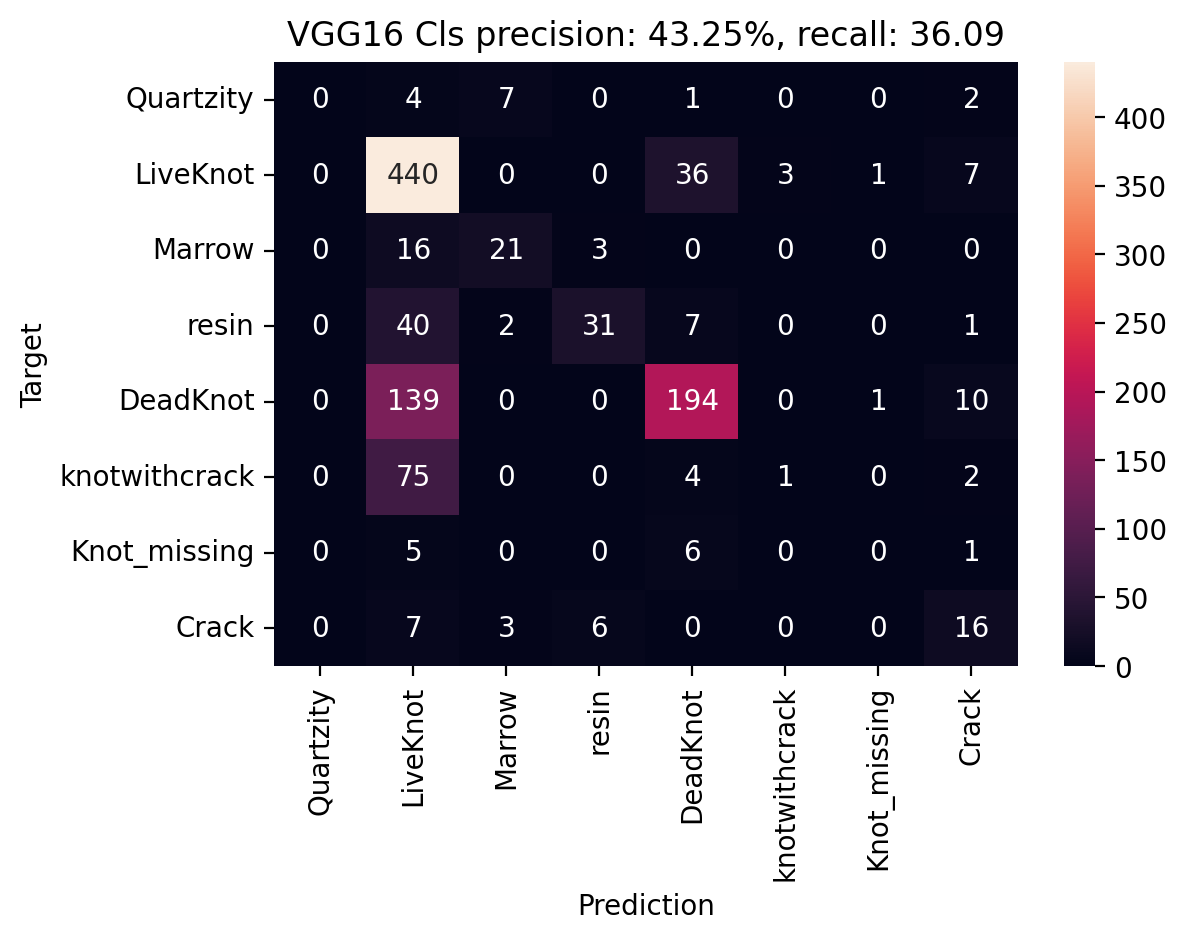

In [ ]:
import seaborn as sn
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'VGG16 Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', 'VGG16_FRCNN.png'))
           

In [ ]:
import pandas as pd
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']


In [ ]:
df['box_precision'].mean()

0.5518521533200615

In [ ]:
# save_name = 'VGG16_SGD_epoch_20.pth'
# df.to_csv(os.path.join('Validation_csv', save_name.replace('pth', 'csv')))